#  Predicting Audience Ratings: Full Pipeline with Explanation

## **Project Overview**
**Objective**:  
The goal of this project is to predict the **'audience_rating'** of movies using various machine learning models. The process involves handling missing data, training models, comparing performance, and selecting the best-performing model.

**Steps to Follow**:
1. **Data Cleaning**: Handle missing values in 'audience_rating'.  
2. **Data Preparation**: Feature selection, encoding, and splitting data into training and testing sets.  
3. **Model Training**: Train multiple machine learning models.  
4. **Prediction & Evaluation**: Predict and evaluate the model on unseen test data.  
5. **Visualization**: Show the performance metrics before and after predictions.  
6. **Saving & Reuse**: Save the best model and load it for future use.

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time  # For tracking training time

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib


# Load the Dataset & Data Cleaning

In [3]:
# Load the Excel file
file_path = 'Rotten_Tomatoes_Movies3.xls'  # Update this path as needed
df = pd.read_excel(file_path)

# Drop irrelevant columns
columns_to_drop = ['movie_title', 'on_streaming_date', 'in_theaters_date']
df = df.drop(columns=columns_to_drop)

# Handle missing values for categorical and numerical features
categorical_features = df.select_dtypes(include=['object', 'category']).columns
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns

# Drop 'audience_rating' from the list of features (since it's the target)
numerical_features = numerical_features.drop('audience_rating')

# Fill missing values for categorical and numerical features
df[categorical_features] = df[categorical_features].fillna('unknown')
df[numerical_features] = df[numerical_features].fillna(df[numerical_features].mean())

# Check for NaN values in target column
nan_count = df['audience_rating'].isna().sum()
print(f"Number of NaN values in 'audience_rating': {nan_count}")


Number of NaN values in 'audience_rating': 252


# Data Preparation: Handle Missing Values

### Scenario 1 - Replace with Mean

In [7]:
# In this scenario, we replace missing `audience_rating` values with the mean value of the column.
df_mean_filled = df.copy()
mean_value = df_mean_filled['audience_rating'].mean()
df_mean_filled['audience_rating'] = df_mean_filled['audience_rating'].fillna(mean_value)
df_mean_filled['audience_rating'].isnull().sum()

0

### Scenario 2 - Replace with tomatometer_rating

In [9]:
# In this scenario, we replace missing `audience_rating` values with the corresponding `tomatometer_rating` values.
df_tomato_filled = df.copy()
df_tomato_filled['audience_rating'] = df_tomato_filled['audience_rating'].fillna(df_tomato_filled['tomatometer_rating'])
df_tomato_filled['audience_rating'].isnull().sum()

0

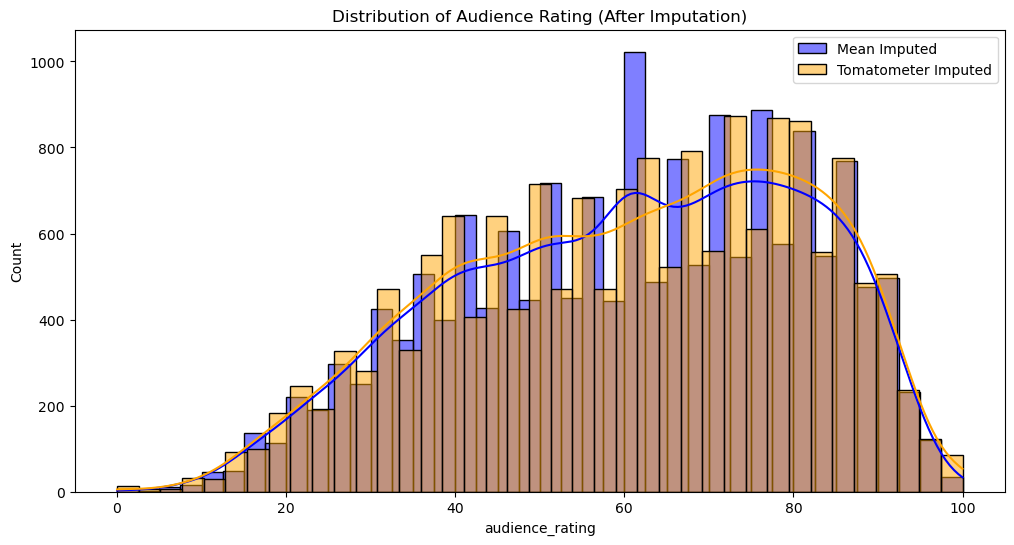

In [11]:
# Visualize the distribution of the target variable
plt.figure(figsize=(12, 6))
sns.histplot(df_mean_filled['audience_rating'], color='blue', label='Mean Imputed', kde=True)
sns.histplot(df_tomato_filled['audience_rating'], color='orange', label='Tomatometer Imputed', kde=True)
plt.title('Distribution of Audience Rating (After Imputation)')
plt.legend()
plt.show()

# Function to Train and Evaluate Models

In [13]:
# This function preprocesses the data, trains multiple models, evaluates their performance, and identifies the best model for a given scenario.

def train_and_evaluate(X_train, X_test, y_train, y_test, model, model_name):
    print(f"Training {model_name}...")
    start_time = time.time()  # Start the timer
    
    model.fit(X_train, y_train)
    
    end_time = time.time()  # End the timer
    training_time = end_time - start_time
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"--- {model_name} ---")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R2): {r2:.4f}")
    print("\n")
    
    return {'model': model_name, 'mse': mse, 'mae': mae, 'r2': r2, 'training_time': training_time}

# Models to train
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42)
}

results = []

# Train and evaluate models for both datasets
for method, df in zip(['Mean Imputation', 'Tomatometer Imputation'], [df_mean_filled, df_tomato_filled]):
    print(f"\n========== Training Models for {method} ==========\n")
    
    X = df.drop(columns=['audience_rating'])
    y = df['audience_rating']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ]
    )
    
    # Process the features
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    # Train each model
    for model_name, model in models.items():
        result = train_and_evaluate(X_train, X_test, y_train, y_test, model, f"{method} - {model_name}")
        results.append(result)


========== Training Models for Mean Imputation ==========

Training Mean Imputation - Random Forest...
--- Mean Imputation - Random Forest ---
Training Time: 431.86 seconds
Mean Squared Error (MSE): 212.1233
Mean Absolute Error (MAE): 11.4361
R-squared (R2): 0.4800


Training Mean Imputation - Gradient Boosting...
--- Mean Imputation - Gradient Boosting ---
Training Time: 10.09 seconds
Mean Squared Error (MSE): 203.2954
Mean Absolute Error (MAE): 11.4153
R-squared (R2): 0.5016


Training Mean Imputation - Linear Regression...
--- Mean Imputation - Linear Regression ---
Training Time: 0.17 seconds
Mean Squared Error (MSE): 193.4632
Mean Absolute Error (MAE): 11.0082
R-squared (R2): 0.5257


Training Mean Imputation - Decision Tree...
--- Mean Imputation - Decision Tree ---
Training Time: 6.32 seconds
Mean Squared Error (MSE): 328.6103
Mean Absolute Error (MAE): 14.2089
R-squared (R2): 0.1944



========== Training Models for Tomatometer Imputation ==========

Training Tomatometer Imput

## **Evaluation & Metrics**

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20912\3058937308.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='mse', data=results_df, palette='viridis')


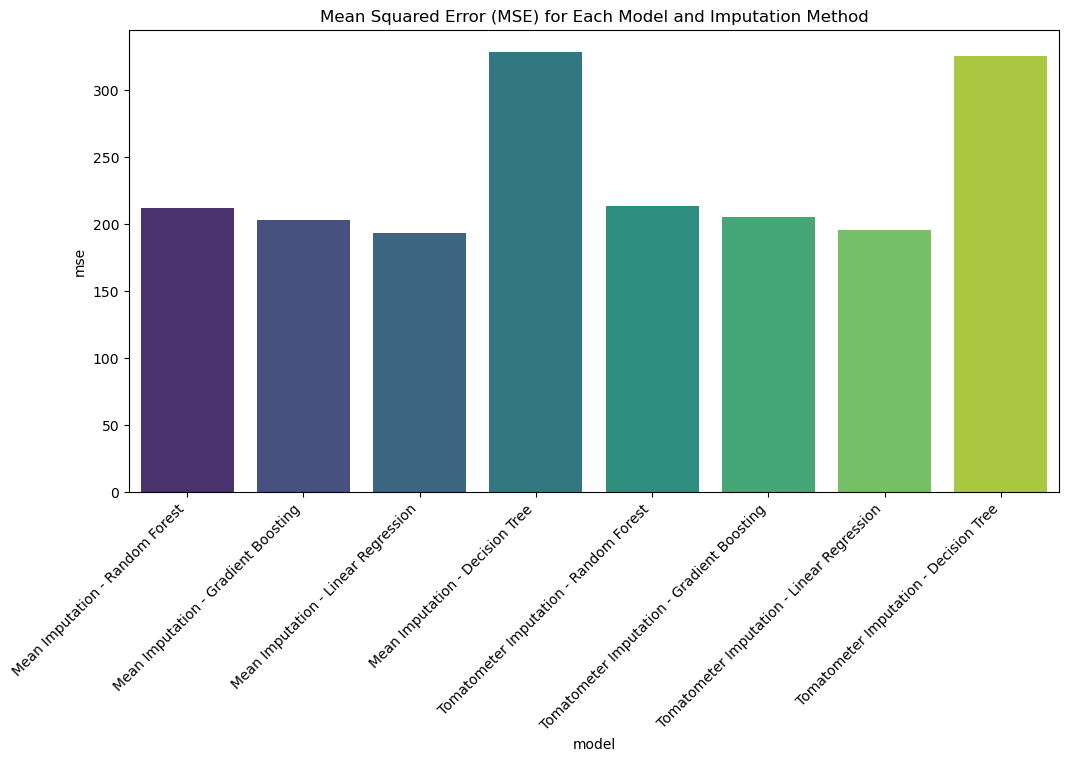

In [19]:
results_df = pd.DataFrame(results)

# Plot MSE, MAE, and R2 for each model
plt.figure(figsize=(12, 6))
sns.barplot(x='model', y='mse', data=results_df, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Mean Squared Error (MSE) for Each Model and Imputation Method')
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20912\3922274662.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='mae', data=results_df, palette='coolwarm')


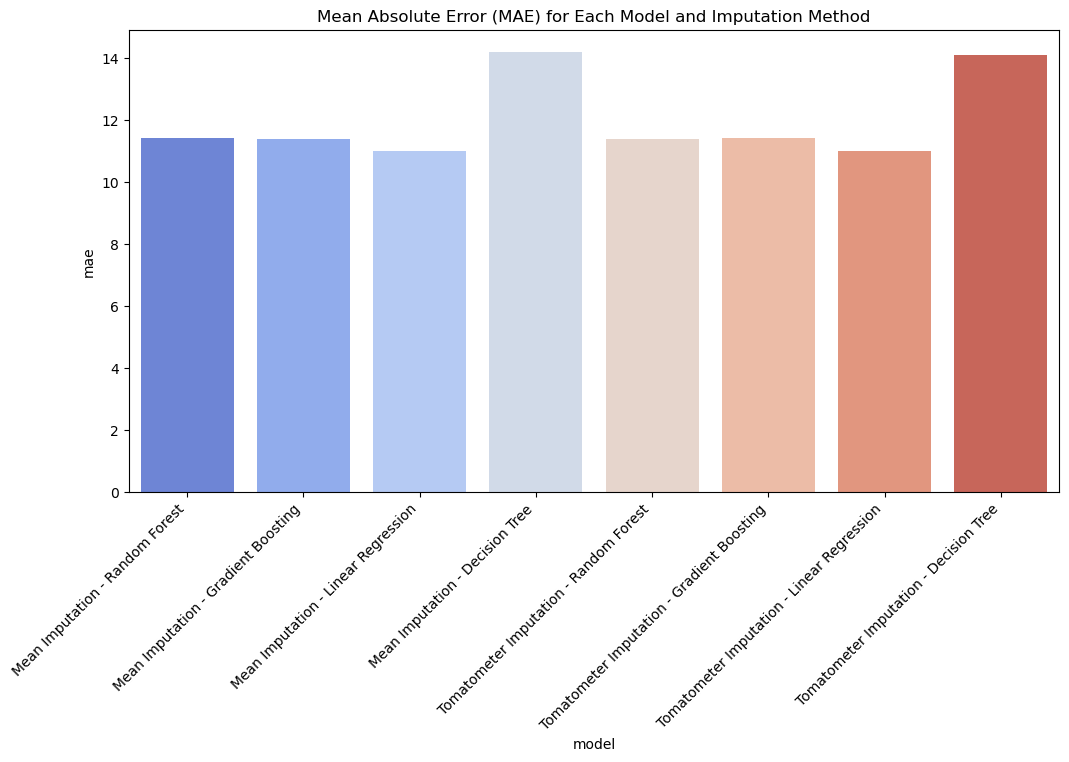

In [21]:
plt.figure(figsize=(12, 6))
sns.barplot(x='model', y='mae', data=results_df, palette='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.title('Mean Absolute Error (MAE) for Each Model and Imputation Method')
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20912\4270780684.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='r2', data=results_df, palette='Spectral')


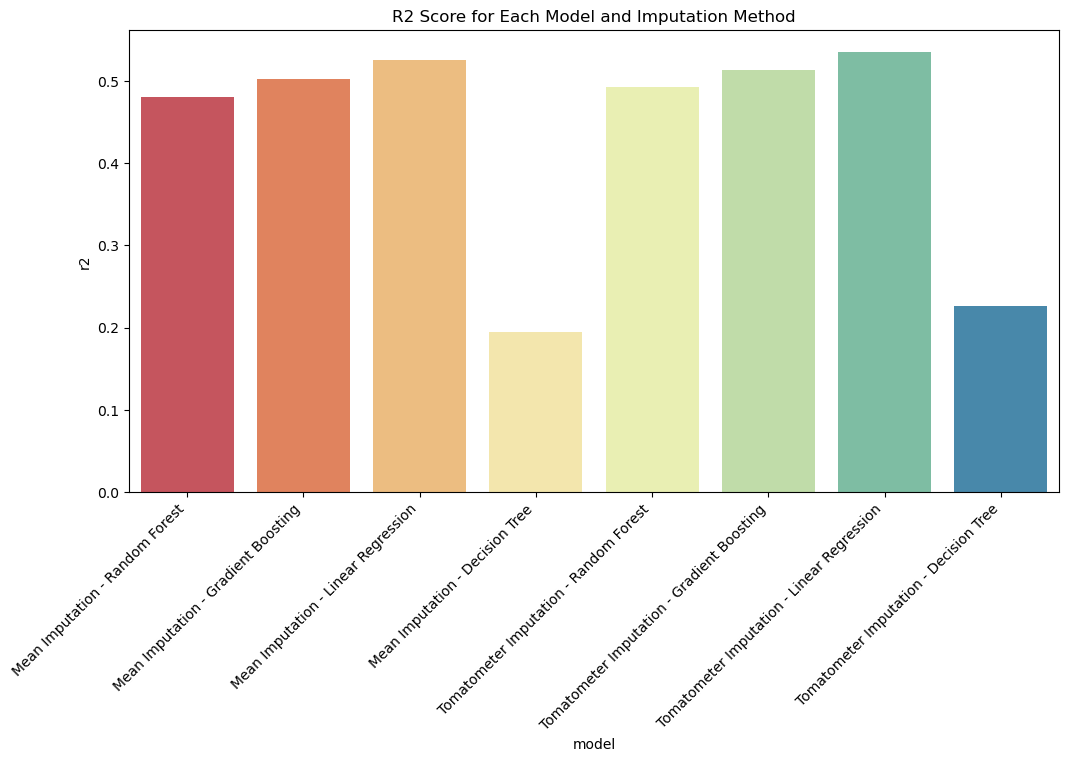

In [23]:
plt.figure(figsize=(12, 6))
sns.barplot(x='model', y='r2', data=results_df, palette='Spectral')
plt.xticks(rotation=45, ha='right')
plt.title('R2 Score for Each Model and Imputation Method')
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20912\1917073338.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='training_time', data=results_df, palette='magma')


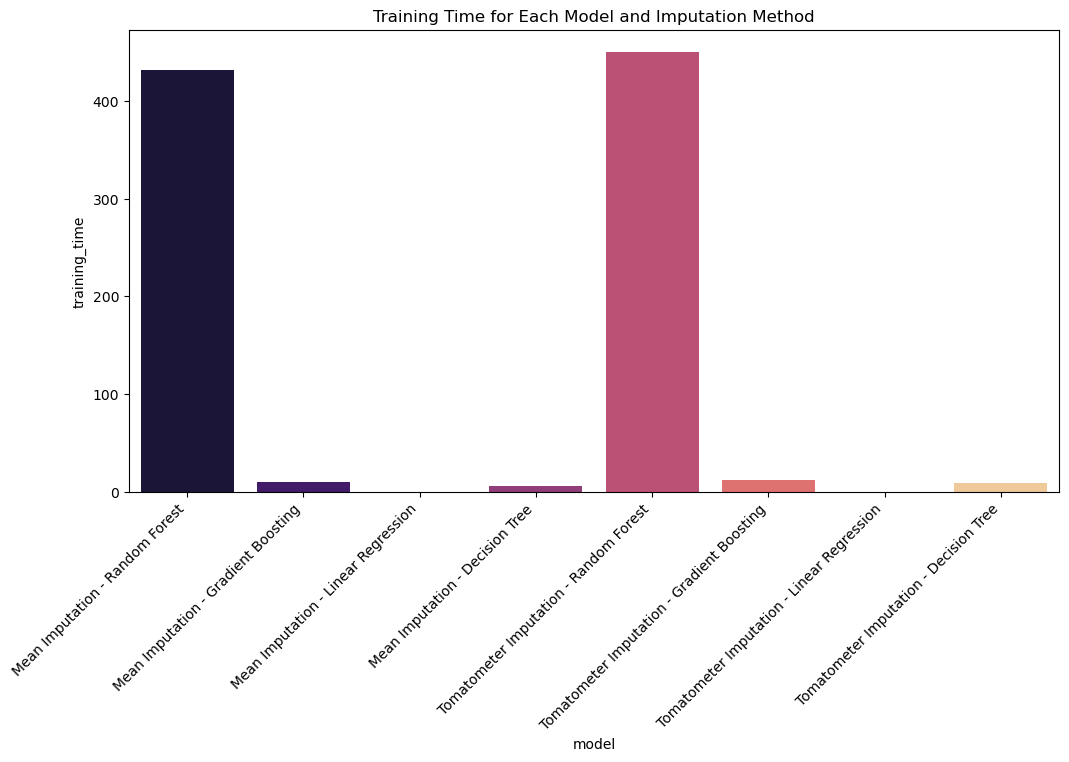

In [25]:
# Plot training time for each model
plt.figure(figsize=(12, 6))
sns.barplot(x='model', y='training_time', data=results_df, palette='magma')
plt.xticks(rotation=45, ha='right')
plt.title('Training Time for Each Model and Imputation Method')
plt.show()

In [17]:
# Select the best model based on MSE
best_model = results_df.sort_values(by='mse', ascending=True).iloc[0]
best_model_name = best_model['model']
print(f"The best model is {best_model_name} with MSE = {best_model['mse']:.4f}")

# Train the best model on the entire dataset
if 'Mean Imputation' in best_model_name:
    final_df = df_mean_filled
else:
    final_df = df_tomato_filled

X = final_df.drop(columns=['audience_rating'])
y = final_df['audience_rating']

# Train the best model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

final_model = RandomForestRegressor(n_estimators=100, random_state=42)
final_model.fit(X_train, y_train)

# Save the model
joblib.dump(final_model, 'best_audience_rating_model.pkl')
print("Best model saved successfully as 'best_audience_rating_model.pkl'")


The best model is Mean Imputation - Linear Regression with MSE = 193.4632
Best model saved successfully as 'best_audience_rating_model.pkl'


## **Prediction After Training**


--- Actual vs. Predicted Audience Ratings ---

   Actual  Predicted
0    44.0  47.170000
1    41.0  57.880000
2    72.0  68.350000
3    87.0  85.200000
4    90.0  83.434708
5    64.0  73.280000
6    39.0  51.830000
7    92.0  69.070000
8    56.0  62.060000
9    46.0  57.370000


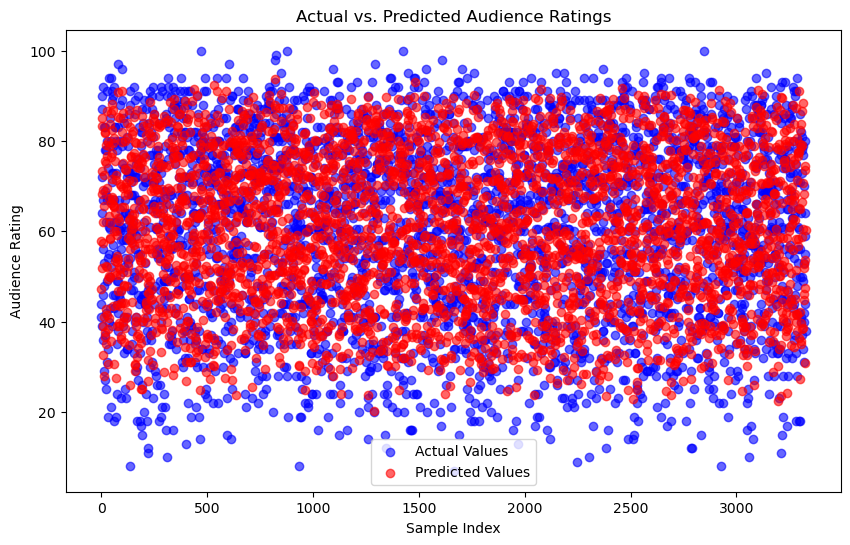

In [27]:
# Predict on the test set using the best model
y_test_pred = final_model.predict(X_test)

# Compare Actual vs Predicted Values
comparison_df = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_test_pred})
print("\n--- Actual vs. Predicted Audience Ratings ---\n")
print(comparison_df.head(10))

# Visualize the Comparison
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual Values', alpha=0.6)
plt.scatter(range(len(y_test_pred)), y_test_pred, color='red', label='Predicted Values', alpha=0.6)
plt.title('Actual vs. Predicted Audience Ratings')
plt.xlabel('Sample Index')
plt.ylabel('Audience Rating')
plt.legend()
plt.show()


In [29]:
# Metrics Before Prediction (from the training process)
print("\n--- Metrics from Training Process ---\n")
print(f"Best Model: {best_model_name}")
print(f"Mean Squared Error (MSE): {best_model['mse']:.4f}")
print(f"Mean Absolute Error (MAE): {best_model['mae']:.4f}")
print(f"R-squared (R2): {best_model['r2']:.4f}")

# Metrics After Prediction (recalculate MSE, MAE, R2)
mse_after = mean_squared_error(y_test, y_test_pred)
mae_after = mean_absolute_error(y_test, y_test_pred)
r2_after = r2_score(y_test, y_test_pred)

print("\n--- Metrics After Prediction ---\n")
print(f"Mean Squared Error (MSE) After Prediction: {mse_after:.4f}")
print(f"Mean Absolute Error (MAE) After Prediction: {mae_after:.4f}")
print(f"R-squared (R2) After Prediction: {r2_after:.4f}")



--- Metrics from Training Process ---

Best Model: Mean Imputation - Linear Regression
Mean Squared Error (MSE): 193.4632
Mean Absolute Error (MAE): 11.0082
R-squared (R2): 0.5257

--- Metrics After Prediction ---

Mean Squared Error (MSE) After Prediction: 212.1233
Mean Absolute Error (MAE) After Prediction: 11.4361
R-squared (R2) After Prediction: 0.4800


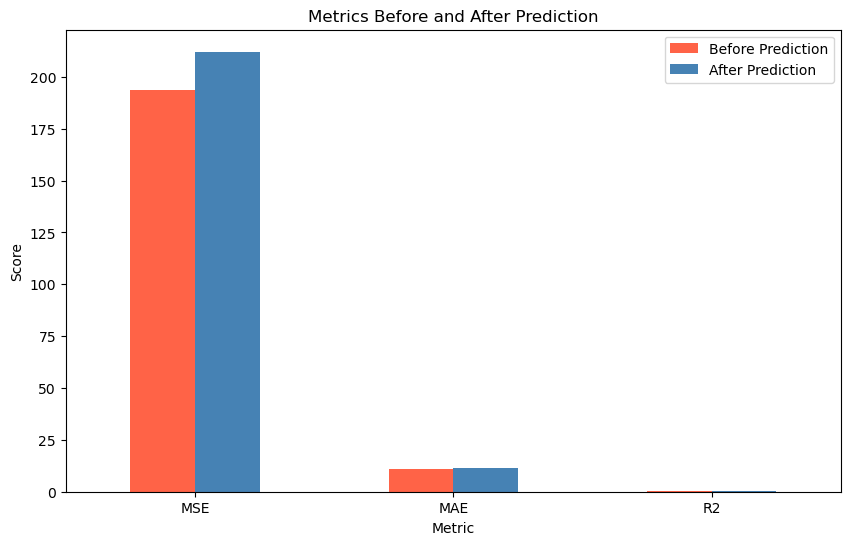

In [31]:
# Metrics Comparison (Before vs. After)
metrics_comparison = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'R2'],
    'Before Prediction': [best_model['mse'], best_model['mae'], best_model['r2']],
    'After Prediction': [mse_after, mae_after, r2_after]
})

# Plot the Before and After Comparison
metrics_comparison.set_index('Metric', inplace=True)
metrics_comparison.plot(kind='bar', figsize=(10, 6), color=['#FF6347', '#4682B4'])
plt.title('Metrics Before and After Prediction')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()


## **Save & Reload Best Model**

In [33]:
# Save the Best Model
joblib.dump(final_model, 'best_audience_rating_model.pkl')
print("\nBest model saved successfully as 'best_audience_rating_model.pkl'")

# Reload the model (to simulate real-world usage)
loaded_model = joblib.load('best_audience_rating_model.pkl')

# Test the reloaded model to ensure it works
sample_data = X_test[0].reshape(1, -1)  # Single sample for prediction
predicted_rating = loaded_model.predict(sample_data)
print(f"\nPredicted Audience Rating for the sample: {predicted_rating[0]:.2f}")



Best model saved successfully as 'best_audience_rating_model.pkl'

Predicted Audience Rating for the sample: 47.17


## **Conclusion**

- We handled missing data using two imputation strategies.  
- We trained multiple models and selected the best-performing one.  
- We saved and reloaded the best model for future predictions.  
- We visualized predictions and performance metrics to understand the quality of the model.